# Overfiting Test

In this experiment, we train lstm model with 2017 data and predict on 2018.
In 2017 dataset, we have 16 cars that finished all laps. In 2018, we have 18.

As the dataset is small, it is vulnerable to the problem of overfitting. 


In [46]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
from sklearn.preprocessing import MinMaxScaler
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [54]:
#
# generate data from time series
#
def generate_data(dataset, D= 1, T = 201, target='rank'):
    # simple input is 18+16 cars with all 201 records sorted
    
    carNumber = int(dataset.shape[0] / T)
    
    if dataset.shape[0] != carNumber * T:
        print('error input shape:', dataset.shape)
        return None
        
    x = np.array(dataset.time_diff).reshape((carNumber,-1))
    if target == 'rank':
        y = np.array(dataset.rank_diff).reshape((carNumber,-1))
    elif target =='time':
        y = np.array(dataset.time_diff).reshape((carNumber,-1))
    else:
        print('error in target setting as', target)
        return None
    
    retlen = T - D
    X_train = x[:, :retlen].reshape((carNumber, retlen, 1))
    y_train = y[:, D:].reshape((carNumber, retlen, 1))
    return X_train,y_train

def plot_examples(X,y,ypreds=None,nm_ypreds=None):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace = 0.32,wspace = 0.15)
    count = 1
    n_ts = X.shape[0]
    num_per_row = 2 if n_ts > 2 else 1
    for irow in range(n_ts):
        ax = fig.add_subplot(int(n_ts+num_per_row -1)/num_per_row,num_per_row,count)
        #ax.set_ylim(-0.5,0.5)
        ax.plot(X[irow,:,0],"--",label="x1")
        ax.plot(y[irow,:,:],marker='.',label="y",linewidth=3,alpha = 0.5)
        ax.set_title("{:}th time series sample".format(irow))
        if ypreds is not None:
            for ypred,nm in zip(ypreds,nm_ypreds):
                ax.plot(ypred[irow,:,:],marker='.',label=nm)   
        count += 1
    plt.legend()
    plt.show()
    if ypreds is not None:
        for y_pred, nm_ypred in zip(ypreds,nm_ypreds):
            loss = np.mean( (y_pred[:,D:,:].flatten() - y[:,D:,:].flatten())**2)
            print("The final validation loss of {} is {:7.6f}".format(
                nm_ypred,loss))


In [47]:
# predict next lap 
D = 5 
T = 201

#
# baseline works to predict the rankdiff or timediff
# it's a standard time series prediction
# 
data2017 = pd.read_csv('2017-completed_laps_diff.csv')
db1_carnum = int(data2017.shape[0] / T)

data2018 = pd.read_csv('2018-completed_laps_diff.csv')
db2_carnum = int(data2018.shape[0] / T)

dataset = data2018.append(data2017)
total_carnum = int(dataset.shape[0] / T)

dataset.info(verbose=True)
print('dataset shape', dataset.shape)

# transform
scaler = MinMaxScaler()
alldata = dataset.copy()
dataset[['rank_diff', 'time_diff']] = scaler.fit_transform(dataset[['rank_diff', 'time_diff']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 3215
Data columns (total 7 columns):
Unnamed: 0        6834 non-null int64
car_number        6834 non-null int64
completed_laps    6834 non-null int64
rank              6834 non-null int64
elapsed_time      6834 non-null float64
rank_diff         6834 non-null float64
time_diff         6834 non-null float64
dtypes: float64(3), int64(4)
memory usage: 427.1 KB
dataset shape (6834, 7)


In [48]:
# generate train/test dataset

#X, y = generate_data(dataset, D=D,T=T, target='rank')
X, y = generate_data(dataset, D=D,T=T, target='time')

#prop_train = 0.8
#ntrain = int(X.shape[0]*prop_train)
#X_train, X_val = X[:ntrain], X[ntrain:]
#y_train, y_val = y[:ntrain], y[ntrain:]

#ntrain = 12
#nval = 3
#ntest = 3

ntrain = db1_carnum
nval = int(db2_carnum / 2)
#ntest = 3


X_train, X_val, X_test = X[:ntrain], X[ntrain:ntrain + nval], X[ntrain + nval:]
y_train, y_val, y_test = y[:ntrain], y[ntrain:ntrain + nval], y[ntrain + nval:]

print('x_train, shape=', X_train.shape)
print('y_train, shape=', y_train.shape)

w = np.zeros(y.shape[:2])
w[:,D:] = 1 
w_train = w
w_train, w_val = w[:ntrain], w[ntrain:ntrain + nval]

x_train, shape= (16, 196, 1)
y_train, shape= (16, 196, 1)


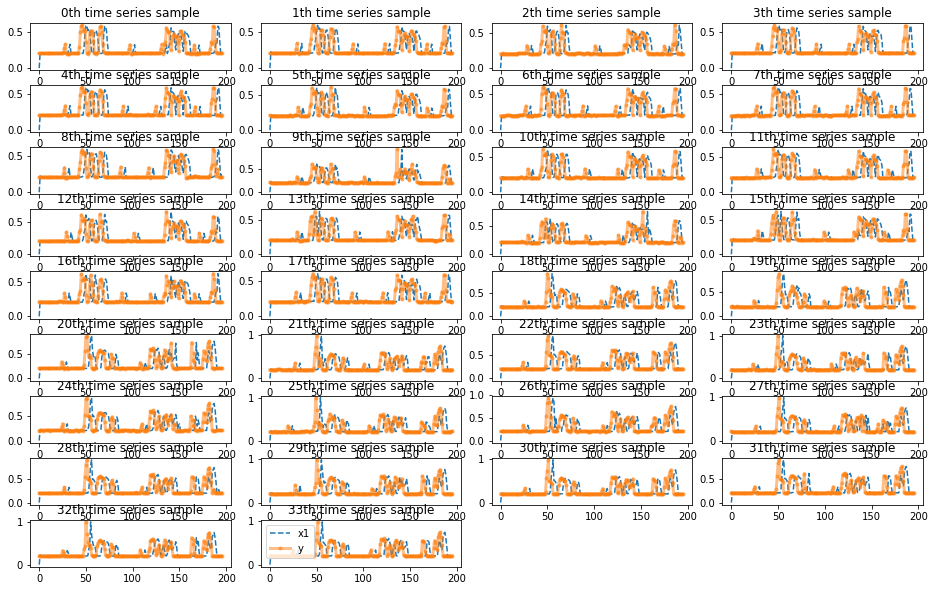

In [49]:
plot_examples(X,y,ypreds=None,nm_ypreds=None)

## Define model

In [50]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(inp,rnn,dens))

In [51]:
hunits = 64
model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 196, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 196, 64)           16896     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 196, 1)            65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


### train for 500 epochs


In [52]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=ntrain,
                             epochs=500,
                             verbose=2,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


Train on 16 samples, validate on 9 samples
Epoch 1/500
 - 1s - loss: 0.0795 - val_loss: 0.0526
Epoch 2/500
 - 0s - loss: 0.0412 - val_loss: 0.0318
Epoch 3/500
 - 0s - loss: 0.0223 - val_loss: 0.0213
Epoch 4/500
 - 0s - loss: 0.0131 - val_loss: 0.0207
Epoch 5/500
 - 0s - loss: 0.0128 - val_loss: 0.0211
Epoch 6/500
 - 0s - loss: 0.0129 - val_loss: 0.0205
Epoch 7/500
 - 0s - loss: 0.0126 - val_loss: 0.0208
Epoch 8/500
 - 0s - loss: 0.0126 - val_loss: 0.0203
Epoch 9/500
 - 0s - loss: 0.0124 - val_loss: 0.0206
Epoch 10/500
 - 0s - loss: 0.0124 - val_loss: 0.0202
Epoch 11/500
 - 0s - loss: 0.0123 - val_loss: 0.0205
Epoch 12/500
 - 0s - loss: 0.0123 - val_loss: 0.0201
Epoch 13/500
 - 0s - loss: 0.0122 - val_loss: 0.0204
Epoch 14/500
 - 0s - loss: 0.0122 - val_loss: 0.0201
Epoch 15/500
 - 0s - loss: 0.0121 - val_loss: 0.0205
Epoch 16/500
 - 0s - loss: 0.0122 - val_loss: 0.0201
Epoch 17/500
 - 0s - loss: 0.0121 - val_loss: 0.0206
Epoch 18/500
 - 0s - loss: 0.0122 - val_loss: 0.0201
Epoch 19/500

Epoch 154/500
 - 0s - loss: 0.0094 - val_loss: 0.0174
Epoch 155/500
 - 0s - loss: 0.0093 - val_loss: 0.0172
Epoch 156/500
 - 0s - loss: 0.0092 - val_loss: 0.0174
Epoch 157/500
 - 0s - loss: 0.0092 - val_loss: 0.0171
Epoch 158/500
 - 0s - loss: 0.0092 - val_loss: 0.0174
Epoch 159/500
 - 0s - loss: 0.0092 - val_loss: 0.0170
Epoch 160/500
 - 0s - loss: 0.0093 - val_loss: 0.0181
Epoch 161/500
 - 0s - loss: 0.0097 - val_loss: 0.0174
Epoch 162/500
 - 0s - loss: 0.0096 - val_loss: 0.0183
Epoch 163/500
 - 0s - loss: 0.0098 - val_loss: 0.0183
Epoch 164/500
 - 0s - loss: 0.0089 - val_loss: 0.0182
Epoch 165/500
 - 0s - loss: 0.0088 - val_loss: 0.0186
Epoch 166/500
 - 0s - loss: 0.0088 - val_loss: 0.0174
Epoch 167/500
 - 0s - loss: 0.0093 - val_loss: 0.0167
Epoch 168/500
 - 0s - loss: 0.0089 - val_loss: 0.0167
Epoch 169/500
 - 0s - loss: 0.0087 - val_loss: 0.0172
Epoch 170/500
 - 0s - loss: 0.0086 - val_loss: 0.0173
Epoch 171/500
 - 0s - loss: 0.0086 - val_loss: 0.0178
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0081 - val_loss: 0.0156
Epoch 307/500
 - 0s - loss: 0.0081 - val_loss: 0.0166
Epoch 308/500
 - 0s - loss: 0.0085 - val_loss: 0.0157
Epoch 309/500
 - 0s - loss: 0.0082 - val_loss: 0.0155
Epoch 310/500
 - 0s - loss: 0.0080 - val_loss: 0.0154
Epoch 311/500
 - 0s - loss: 0.0080 - val_loss: 0.0168
Epoch 312/500
 - 0s - loss: 0.0084 - val_loss: 0.0156
Epoch 313/500
 - 0s - loss: 0.0097 - val_loss: 0.0206
Epoch 314/500
 - 0s - loss: 0.0114 - val_loss: 0.0161
Epoch 315/500
 - 0s - loss: 0.0084 - val_loss: 0.0159
Epoch 316/500
 - 0s - loss: 0.0083 - val_loss: 0.0158
Epoch 317/500
 - 0s - loss: 0.0082 - val_loss: 0.0157
Epoch 318/500
 - 0s - loss: 0.0082 - val_loss: 0.0158
Epoch 319/500
 - 0s - loss: 0.0082 - val_loss: 0.0158
Epoch 320/500
 - 0s - loss: 0.0083 - val_loss: 0.0169
Epoch 321/500
 - 0s - loss: 0.0086 - val_loss: 0.0161
Epoch 322/500
 - 0s - loss: 0.0083 - val_loss: 0.0156
Epoch 323/500
 - 0s - loss: 0.0081 - val_loss: 0.0157
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0081 - val_loss: 0.0177
Epoch 459/500
 - 0s - loss: 0.0069 - val_loss: 0.0168
Epoch 460/500
 - 0s - loss: 0.0071 - val_loss: 0.0176
Epoch 461/500
 - 0s - loss: 0.0070 - val_loss: 0.0157
Epoch 462/500
 - 0s - loss: 0.0066 - val_loss: 0.0170
Epoch 463/500
 - 0s - loss: 0.0062 - val_loss: 0.0159
Epoch 464/500
 - 0s - loss: 0.0062 - val_loss: 0.0189
Epoch 465/500
 - 0s - loss: 0.0073 - val_loss: 0.0152
Epoch 466/500
 - 0s - loss: 0.0073 - val_loss: 0.0195
Epoch 467/500
 - 0s - loss: 0.0084 - val_loss: 0.0168
Epoch 468/500
 - 0s - loss: 0.0069 - val_loss: 0.0173
Epoch 469/500
 - 0s - loss: 0.0070 - val_loss: 0.0163
Epoch 470/500
 - 0s - loss: 0.0062 - val_loss: 0.0163
Epoch 471/500
 - 0s - loss: 0.0069 - val_loss: 0.0175
Epoch 472/500
 - 0s - loss: 0.0073 - val_loss: 0.0158
Epoch 473/500
 - 0s - loss: 0.0068 - val_loss: 0.0154
Epoch 474/500
 - 0s - loss: 0.0063 - val_loss: 0.0169
Epoch 475/500
 - 0s - loss: 0.0066 - val_loss: 0.0159
Epoch 476/500
 - 0s - loss: 

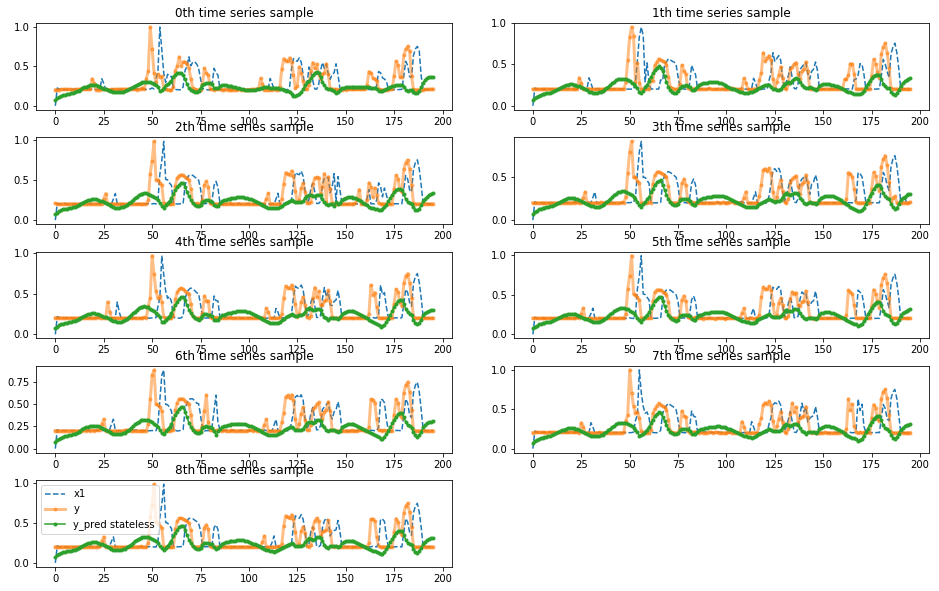

The final validation loss of y_pred stateless is 0.021738


In [55]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

### train for 2000 epochs
It is amazing to see the capacity of the model, which predicts the pikes of crashes ''accurately''.
However, the performance goes worse in the cases of pitstops. They are totally ignored.
Overfitting must occur here.
To verify that, let''s train on data of a different event, such as train on 2017 and then test on 2018. 
Another idea is to modify the loss funtion to emphysize on pitstops.



In [56]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=ntrain,
                             epochs=2000,
                             verbose=2,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


Train on 16 samples, validate on 9 samples
Epoch 1/2000
 - 0s - loss: 0.0078 - val_loss: 0.0149
Epoch 2/2000
 - 0s - loss: 0.0058 - val_loss: 0.0158
Epoch 3/2000
 - 0s - loss: 0.0057 - val_loss: 0.0164
Epoch 4/2000
 - 0s - loss: 0.0075 - val_loss: 0.0166
Epoch 5/2000
 - 0s - loss: 0.0093 - val_loss: 0.0157
Epoch 6/2000
 - 0s - loss: 0.0089 - val_loss: 0.0180
Epoch 7/2000
 - 0s - loss: 0.0081 - val_loss: 0.0168
Epoch 8/2000
 - 0s - loss: 0.0074 - val_loss: 0.0163
Epoch 9/2000
 - 0s - loss: 0.0068 - val_loss: 0.0160
Epoch 10/2000
 - 0s - loss: 0.0063 - val_loss: 0.0160
Epoch 11/2000
 - 0s - loss: 0.0059 - val_loss: 0.0161
Epoch 12/2000
 - 0s - loss: 0.0057 - val_loss: 0.0160
Epoch 13/2000
 - 0s - loss: 0.0055 - val_loss: 0.0159
Epoch 14/2000
 - 0s - loss: 0.0053 - val_loss: 0.0157
Epoch 15/2000
 - 0s - loss: 0.0052 - val_loss: 0.0156
Epoch 16/2000
 - 0s - loss: 0.0052 - val_loss: 0.0156
Epoch 17/2000
 - 0s - loss: 0.0052 - val_loss: 0.0157
Epoch 18/2000
 - 0s - loss: 0.0056 - val_loss: 0

 - 0s - loss: 0.0057 - val_loss: 0.0155
Epoch 152/2000
 - 0s - loss: 0.0060 - val_loss: 0.0156
Epoch 153/2000
 - 0s - loss: 0.0049 - val_loss: 0.0159
Epoch 154/2000
 - 0s - loss: 0.0041 - val_loss: 0.0169
Epoch 155/2000
 - 0s - loss: 0.0038 - val_loss: 0.0168
Epoch 156/2000
 - 0s - loss: 0.0037 - val_loss: 0.0172
Epoch 157/2000
 - 0s - loss: 0.0038 - val_loss: 0.0167
Epoch 158/2000
 - 0s - loss: 0.0039 - val_loss: 0.0186
Epoch 159/2000
 - 0s - loss: 0.0048 - val_loss: 0.0164
Epoch 160/2000
 - 0s - loss: 0.0052 - val_loss: 0.0186
Epoch 161/2000
 - 0s - loss: 0.0051 - val_loss: 0.0161
Epoch 162/2000
 - 0s - loss: 0.0047 - val_loss: 0.0198
Epoch 163/2000
 - 0s - loss: 0.0058 - val_loss: 0.0179
Epoch 164/2000
 - 0s - loss: 0.0057 - val_loss: 0.0173
Epoch 165/2000
 - 0s - loss: 0.0052 - val_loss: 0.0182
Epoch 166/2000
 - 0s - loss: 0.0044 - val_loss: 0.0170
Epoch 167/2000
 - 0s - loss: 0.0045 - val_loss: 0.0179
Epoch 168/2000
 - 0s - loss: 0.0042 - val_loss: 0.0172
Epoch 169/2000
 - 0s - lo

 - 0s - loss: 0.0043 - val_loss: 0.0183
Epoch 301/2000
 - 0s - loss: 0.0045 - val_loss: 0.0184
Epoch 302/2000
 - 0s - loss: 0.0045 - val_loss: 0.0186
Epoch 303/2000
 - 0s - loss: 0.0037 - val_loss: 0.0183
Epoch 304/2000
 - 0s - loss: 0.0029 - val_loss: 0.0189
Epoch 305/2000
 - 0s - loss: 0.0027 - val_loss: 0.0193
Epoch 306/2000
 - 0s - loss: 0.0027 - val_loss: 0.0194
Epoch 307/2000
 - 0s - loss: 0.0027 - val_loss: 0.0195
Epoch 308/2000
 - 0s - loss: 0.0030 - val_loss: 0.0200
Epoch 309/2000
 - 0s - loss: 0.0035 - val_loss: 0.0186
Epoch 310/2000
 - 0s - loss: 0.0043 - val_loss: 0.0203
Epoch 311/2000
 - 0s - loss: 0.0037 - val_loss: 0.0179
Epoch 312/2000
 - 0s - loss: 0.0038 - val_loss: 0.0211
Epoch 313/2000
 - 0s - loss: 0.0035 - val_loss: 0.0180
Epoch 314/2000
 - 0s - loss: 0.0041 - val_loss: 0.0211
Epoch 315/2000
 - 0s - loss: 0.0035 - val_loss: 0.0178
Epoch 316/2000
 - 0s - loss: 0.0040 - val_loss: 0.0198
Epoch 317/2000
 - 0s - loss: 0.0032 - val_loss: 0.0179
Epoch 318/2000
 - 0s - lo

 - 0s - loss: 0.0028 - val_loss: 0.0213
Epoch 450/2000
 - 0s - loss: 0.0029 - val_loss: 0.0199
Epoch 451/2000
 - 0s - loss: 0.0031 - val_loss: 0.0228
Epoch 452/2000
 - 0s - loss: 0.0029 - val_loss: 0.0192
Epoch 453/2000
 - 0s - loss: 0.0035 - val_loss: 0.0233
Epoch 454/2000
 - 0s - loss: 0.0038 - val_loss: 0.0196
Epoch 455/2000
 - 0s - loss: 0.0041 - val_loss: 0.0219
Epoch 456/2000
 - 0s - loss: 0.0031 - val_loss: 0.0192
Epoch 457/2000
 - 0s - loss: 0.0036 - val_loss: 0.0219
Epoch 458/2000
 - 0s - loss: 0.0033 - val_loss: 0.0196
Epoch 459/2000
 - 0s - loss: 0.0032 - val_loss: 0.0208
Epoch 460/2000
 - 0s - loss: 0.0027 - val_loss: 0.0196
Epoch 461/2000
 - 0s - loss: 0.0028 - val_loss: 0.0208
Epoch 462/2000
 - 0s - loss: 0.0028 - val_loss: 0.0201
Epoch 463/2000
 - 0s - loss: 0.0029 - val_loss: 0.0203
Epoch 464/2000
 - 0s - loss: 0.0029 - val_loss: 0.0200
Epoch 465/2000
 - 0s - loss: 0.0028 - val_loss: 0.0201
Epoch 466/2000
 - 0s - loss: 0.0028 - val_loss: 0.0216
Epoch 467/2000
 - 0s - lo

Epoch 599/2000
 - 0s - loss: 0.0038 - val_loss: 0.0197
Epoch 600/2000
 - 0s - loss: 0.0040 - val_loss: 0.0211
Epoch 601/2000
 - 0s - loss: 0.0037 - val_loss: 0.0201
Epoch 602/2000
 - 0s - loss: 0.0030 - val_loss: 0.0219
Epoch 603/2000
 - 0s - loss: 0.0027 - val_loss: 0.0220
Epoch 604/2000
 - 0s - loss: 0.0023 - val_loss: 0.0219
Epoch 605/2000
 - 0s - loss: 0.0023 - val_loss: 0.0208
Epoch 606/2000
 - 0s - loss: 0.0023 - val_loss: 0.0237
Epoch 607/2000
 - 0s - loss: 0.0026 - val_loss: 0.0205
Epoch 608/2000
 - 0s - loss: 0.0033 - val_loss: 0.0234
Epoch 609/2000
 - 0s - loss: 0.0028 - val_loss: 0.0205
Epoch 610/2000
 - 0s - loss: 0.0030 - val_loss: 0.0227
Epoch 611/2000
 - 0s - loss: 0.0026 - val_loss: 0.0209
Epoch 612/2000
 - 0s - loss: 0.0024 - val_loss: 0.0217
Epoch 613/2000
 - 0s - loss: 0.0025 - val_loss: 0.0215
Epoch 614/2000
 - 0s - loss: 0.0022 - val_loss: 0.0211
Epoch 615/2000
 - 0s - loss: 0.0023 - val_loss: 0.0221
Epoch 616/2000
 - 0s - loss: 0.0021 - val_loss: 0.0207
Epoch 617/

Epoch 748/2000
 - 0s - loss: 0.0028 - val_loss: 0.0230
Epoch 749/2000
 - 0s - loss: 0.0032 - val_loss: 0.0236
Epoch 750/2000
 - 0s - loss: 0.0042 - val_loss: 0.0216
Epoch 751/2000
 - 0s - loss: 0.0042 - val_loss: 0.0212
Epoch 752/2000
 - 0s - loss: 0.0030 - val_loss: 0.0218
Epoch 753/2000
 - 0s - loss: 0.0021 - val_loss: 0.0222
Epoch 754/2000
 - 0s - loss: 0.0019 - val_loss: 0.0224
Epoch 755/2000
 - 0s - loss: 0.0019 - val_loss: 0.0226
Epoch 756/2000
 - 0s - loss: 0.0019 - val_loss: 0.0225
Epoch 757/2000
 - 0s - loss: 0.0020 - val_loss: 0.0230
Epoch 758/2000
 - 0s - loss: 0.0022 - val_loss: 0.0221
Epoch 759/2000
 - 0s - loss: 0.0026 - val_loss: 0.0232
Epoch 760/2000
 - 0s - loss: 0.0025 - val_loss: 0.0214
Epoch 761/2000
 - 0s - loss: 0.0025 - val_loss: 0.0235
Epoch 762/2000
 - 0s - loss: 0.0026 - val_loss: 0.0215
Epoch 763/2000
 - 0s - loss: 0.0024 - val_loss: 0.0237
Epoch 764/2000
 - 0s - loss: 0.0023 - val_loss: 0.0219
Epoch 765/2000
 - 0s - loss: 0.0022 - val_loss: 0.0239
Epoch 766/

Epoch 897/2000
 - 0s - loss: 0.0020 - val_loss: 0.0224
Epoch 898/2000
 - 0s - loss: 0.0019 - val_loss: 0.0230
Epoch 899/2000
 - 0s - loss: 0.0023 - val_loss: 0.0215
Epoch 900/2000
 - 0s - loss: 0.0031 - val_loss: 0.0236
Epoch 901/2000
 - 0s - loss: 0.0035 - val_loss: 0.0203
Epoch 902/2000
 - 0s - loss: 0.0032 - val_loss: 0.0216
Epoch 903/2000
 - 0s - loss: 0.0026 - val_loss: 0.0224
Epoch 904/2000
 - 0s - loss: 0.0024 - val_loss: 0.0225
Epoch 905/2000
 - 0s - loss: 0.0029 - val_loss: 0.0239
Epoch 906/2000
 - 0s - loss: 0.0024 - val_loss: 0.0225
Epoch 907/2000
 - 0s - loss: 0.0025 - val_loss: 0.0228
Epoch 908/2000
 - 0s - loss: 0.0023 - val_loss: 0.0224
Epoch 909/2000
 - 0s - loss: 0.0022 - val_loss: 0.0224
Epoch 910/2000
 - 0s - loss: 0.0020 - val_loss: 0.0229
Epoch 911/2000
 - 0s - loss: 0.0019 - val_loss: 0.0224
Epoch 912/2000
 - 0s - loss: 0.0020 - val_loss: 0.0232
Epoch 913/2000
 - 0s - loss: 0.0021 - val_loss: 0.0224
Epoch 914/2000
 - 0s - loss: 0.0024 - val_loss: 0.0242
Epoch 915/

 - 0s - loss: 0.0022 - val_loss: 0.0227
Epoch 1046/2000
 - 0s - loss: 0.0018 - val_loss: 0.0232
Epoch 1047/2000
 - 0s - loss: 0.0026 - val_loss: 0.0211
Epoch 1048/2000
 - 0s - loss: 0.0032 - val_loss: 0.0220
Epoch 1049/2000
 - 0s - loss: 0.0022 - val_loss: 0.0224
Epoch 1050/2000
 - 0s - loss: 0.0019 - val_loss: 0.0234
Epoch 1051/2000
 - 0s - loss: 0.0019 - val_loss: 0.0225
Epoch 1052/2000
 - 0s - loss: 0.0020 - val_loss: 0.0240
Epoch 1053/2000
 - 0s - loss: 0.0022 - val_loss: 0.0226
Epoch 1054/2000
 - 0s - loss: 0.0027 - val_loss: 0.0233
Epoch 1055/2000
 - 0s - loss: 0.0023 - val_loss: 0.0223
Epoch 1056/2000
 - 0s - loss: 0.0023 - val_loss: 0.0237
Epoch 1057/2000
 - 0s - loss: 0.0020 - val_loss: 0.0224
Epoch 1058/2000
 - 0s - loss: 0.0018 - val_loss: 0.0238
Epoch 1059/2000
 - 0s - loss: 0.0018 - val_loss: 0.0225
Epoch 1060/2000
 - 0s - loss: 0.0018 - val_loss: 0.0238
Epoch 1061/2000
 - 0s - loss: 0.0021 - val_loss: 0.0223
Epoch 1062/2000
 - 0s - loss: 0.0022 - val_loss: 0.0236
Epoch 10

Epoch 1192/2000
 - 0s - loss: 0.0023 - val_loss: 0.0229
Epoch 1193/2000
 - 0s - loss: 0.0017 - val_loss: 0.0230
Epoch 1194/2000
 - 0s - loss: 0.0017 - val_loss: 0.0229
Epoch 1195/2000
 - 0s - loss: 0.0019 - val_loss: 0.0230
Epoch 1196/2000
 - 0s - loss: 0.0019 - val_loss: 0.0225
Epoch 1197/2000
 - 0s - loss: 0.0019 - val_loss: 0.0234
Epoch 1198/2000
 - 0s - loss: 0.0017 - val_loss: 0.0224
Epoch 1199/2000
 - 0s - loss: 0.0018 - val_loss: 0.0240
Epoch 1200/2000
 - 0s - loss: 0.0019 - val_loss: 0.0222
Epoch 1201/2000
 - 0s - loss: 0.0021 - val_loss: 0.0242
Epoch 1202/2000
 - 0s - loss: 0.0024 - val_loss: 0.0222
Epoch 1203/2000
 - 0s - loss: 0.0021 - val_loss: 0.0239
Epoch 1204/2000
 - 0s - loss: 0.0020 - val_loss: 0.0224
Epoch 1205/2000
 - 0s - loss: 0.0018 - val_loss: 0.0237
Epoch 1206/2000
 - 0s - loss: 0.0017 - val_loss: 0.0224
Epoch 1207/2000
 - 0s - loss: 0.0018 - val_loss: 0.0240
Epoch 1208/2000
 - 0s - loss: 0.0021 - val_loss: 0.0224
Epoch 1209/2000
 - 0s - loss: 0.0030 - val_loss:

Epoch 1339/2000
 - 0s - loss: 0.0019 - val_loss: 0.0226
Epoch 1340/2000
 - 0s - loss: 0.0019 - val_loss: 0.0227
Epoch 1341/2000
 - 0s - loss: 0.0021 - val_loss: 0.0225
Epoch 1342/2000
 - 0s - loss: 0.0020 - val_loss: 0.0223
Epoch 1343/2000
 - 0s - loss: 0.0019 - val_loss: 0.0223
Epoch 1344/2000
 - 0s - loss: 0.0019 - val_loss: 0.0235
Epoch 1345/2000
 - 0s - loss: 0.0022 - val_loss: 0.0220
Epoch 1346/2000
 - 0s - loss: 0.0019 - val_loss: 0.0236
Epoch 1347/2000
 - 0s - loss: 0.0017 - val_loss: 0.0220
Epoch 1348/2000
 - 0s - loss: 0.0017 - val_loss: 0.0240
Epoch 1349/2000
 - 0s - loss: 0.0019 - val_loss: 0.0218
Epoch 1350/2000
 - 0s - loss: 0.0020 - val_loss: 0.0245
Epoch 1351/2000
 - 0s - loss: 0.0020 - val_loss: 0.0221
Epoch 1352/2000
 - 0s - loss: 0.0021 - val_loss: 0.0244
Epoch 1353/2000
 - 0s - loss: 0.0020 - val_loss: 0.0225
Epoch 1354/2000
 - 0s - loss: 0.0023 - val_loss: 0.0228
Epoch 1355/2000
 - 0s - loss: 0.0021 - val_loss: 0.0225
Epoch 1356/2000
 - 0s - loss: 0.0027 - val_loss:

Epoch 1486/2000
 - 0s - loss: 0.0018 - val_loss: 0.0234
Epoch 1487/2000
 - 0s - loss: 0.0018 - val_loss: 0.0223
Epoch 1488/2000
 - 0s - loss: 0.0016 - val_loss: 0.0233
Epoch 1489/2000
 - 0s - loss: 0.0016 - val_loss: 0.0223
Epoch 1490/2000
 - 0s - loss: 0.0016 - val_loss: 0.0230
Epoch 1491/2000
 - 0s - loss: 0.0016 - val_loss: 0.0229
Epoch 1492/2000
 - 0s - loss: 0.0021 - val_loss: 0.0221
Epoch 1493/2000
 - 0s - loss: 0.0027 - val_loss: 0.0227
Epoch 1494/2000
 - 0s - loss: 0.0051 - val_loss: 0.0217
Epoch 1495/2000
 - 0s - loss: 0.0043 - val_loss: 0.0227
Epoch 1496/2000
 - 0s - loss: 0.0021 - val_loss: 0.0217
Epoch 1497/2000
 - 0s - loss: 0.0016 - val_loss: 0.0232
Epoch 1498/2000
 - 0s - loss: 0.0015 - val_loss: 0.0221
Epoch 1499/2000
 - 0s - loss: 0.0016 - val_loss: 0.0234
Epoch 1500/2000
 - 0s - loss: 0.0015 - val_loss: 0.0223
Epoch 1501/2000
 - 0s - loss: 0.0017 - val_loss: 0.0236
Epoch 1502/2000
 - 0s - loss: 0.0016 - val_loss: 0.0224
Epoch 1503/2000
 - 0s - loss: 0.0017 - val_loss:

Epoch 1633/2000
 - 0s - loss: 0.0016 - val_loss: 0.0236
Epoch 1634/2000
 - 0s - loss: 0.0018 - val_loss: 0.0224
Epoch 1635/2000
 - 0s - loss: 0.0022 - val_loss: 0.0224
Epoch 1636/2000
 - 0s - loss: 0.0024 - val_loss: 0.0238
Epoch 1637/2000
 - 0s - loss: 0.0029 - val_loss: 0.0216
Epoch 1638/2000
 - 0s - loss: 0.0021 - val_loss: 0.0226
Epoch 1639/2000
 - 0s - loss: 0.0014 - val_loss: 0.0223
Epoch 1640/2000
 - 0s - loss: 0.0015 - val_loss: 0.0225
Epoch 1641/2000
 - 0s - loss: 0.0017 - val_loss: 0.0221
Epoch 1642/2000
 - 0s - loss: 0.0014 - val_loss: 0.0237
Epoch 1643/2000
 - 0s - loss: 0.0016 - val_loss: 0.0225
Epoch 1644/2000
 - 0s - loss: 0.0022 - val_loss: 0.0244
Epoch 1645/2000
 - 0s - loss: 0.0021 - val_loss: 0.0221
Epoch 1646/2000
 - 0s - loss: 0.0017 - val_loss: 0.0242
Epoch 1647/2000
 - 0s - loss: 0.0016 - val_loss: 0.0221
Epoch 1648/2000
 - 0s - loss: 0.0018 - val_loss: 0.0237
Epoch 1649/2000
 - 0s - loss: 0.0017 - val_loss: 0.0224
Epoch 1650/2000
 - 0s - loss: 0.0018 - val_loss:

Epoch 1780/2000
 - 0s - loss: 0.0017 - val_loss: 0.0239
Epoch 1781/2000
 - 0s - loss: 0.0016 - val_loss: 0.0220
Epoch 1782/2000
 - 0s - loss: 0.0016 - val_loss: 0.0236
Epoch 1783/2000
 - 0s - loss: 0.0015 - val_loss: 0.0222
Epoch 1784/2000
 - 0s - loss: 0.0015 - val_loss: 0.0230
Epoch 1785/2000
 - 0s - loss: 0.0016 - val_loss: 0.0223
Epoch 1786/2000
 - 0s - loss: 0.0016 - val_loss: 0.0229
Epoch 1787/2000
 - 0s - loss: 0.0015 - val_loss: 0.0221
Epoch 1788/2000
 - 0s - loss: 0.0017 - val_loss: 0.0233
Epoch 1789/2000
 - 0s - loss: 0.0018 - val_loss: 0.0217
Epoch 1790/2000
 - 0s - loss: 0.0020 - val_loss: 0.0227
Epoch 1791/2000
 - 0s - loss: 0.0016 - val_loss: 0.0220
Epoch 1792/2000
 - 0s - loss: 0.0016 - val_loss: 0.0227
Epoch 1793/2000
 - 0s - loss: 0.0018 - val_loss: 0.0224
Epoch 1794/2000
 - 0s - loss: 0.0016 - val_loss: 0.0225
Epoch 1795/2000
 - 0s - loss: 0.0015 - val_loss: 0.0230
Epoch 1796/2000
 - 0s - loss: 0.0014 - val_loss: 0.0224
Epoch 1797/2000
 - 0s - loss: 0.0015 - val_loss:

Epoch 1927/2000
 - 0s - loss: 0.0016 - val_loss: 0.0224
Epoch 1928/2000
 - 0s - loss: 0.0018 - val_loss: 0.0229
Epoch 1929/2000
 - 0s - loss: 0.0018 - val_loss: 0.0229
Epoch 1930/2000
 - 0s - loss: 0.0018 - val_loss: 0.0223
Epoch 1931/2000
 - 0s - loss: 0.0017 - val_loss: 0.0222
Epoch 1932/2000
 - 0s - loss: 0.0017 - val_loss: 0.0210
Epoch 1933/2000
 - 0s - loss: 0.0017 - val_loss: 0.0226
Epoch 1934/2000
 - 0s - loss: 0.0015 - val_loss: 0.0222
Epoch 1935/2000
 - 0s - loss: 0.0015 - val_loss: 0.0229
Epoch 1936/2000
 - 0s - loss: 0.0017 - val_loss: 0.0228
Epoch 1937/2000
 - 0s - loss: 0.0014 - val_loss: 0.0223
Epoch 1938/2000
 - 0s - loss: 0.0015 - val_loss: 0.0238
Epoch 1939/2000
 - 0s - loss: 0.0014 - val_loss: 0.0220
Epoch 1940/2000
 - 0s - loss: 0.0017 - val_loss: 0.0249
Epoch 1941/2000
 - 0s - loss: 0.0021 - val_loss: 0.0210
Epoch 1942/2000
 - 0s - loss: 0.0026 - val_loss: 0.0231
Epoch 1943/2000
 - 0s - loss: 0.0015 - val_loss: 0.0220
Epoch 1944/2000
 - 0s - loss: 0.0019 - val_loss:

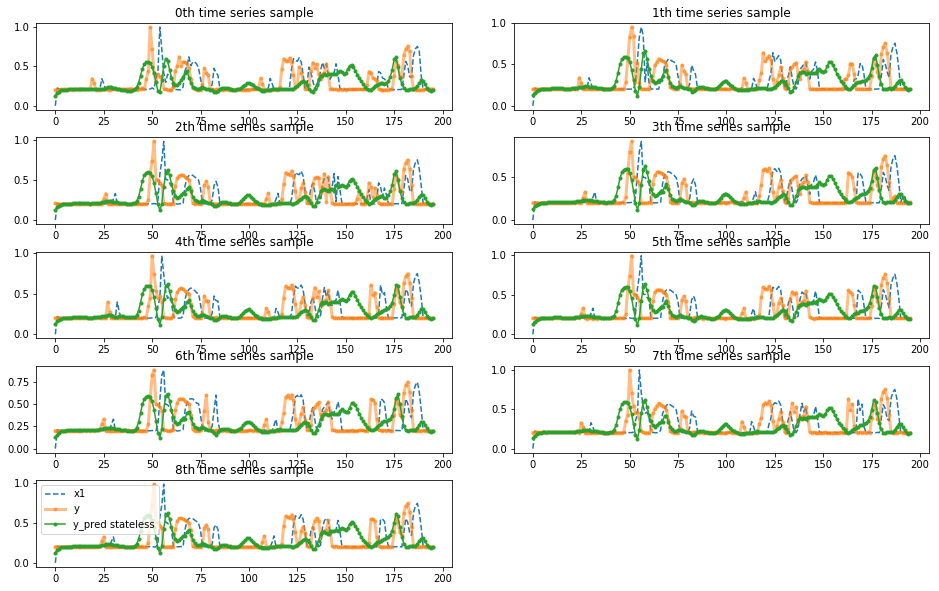

The final validation loss of y_pred stateless is 0.029551


In [57]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

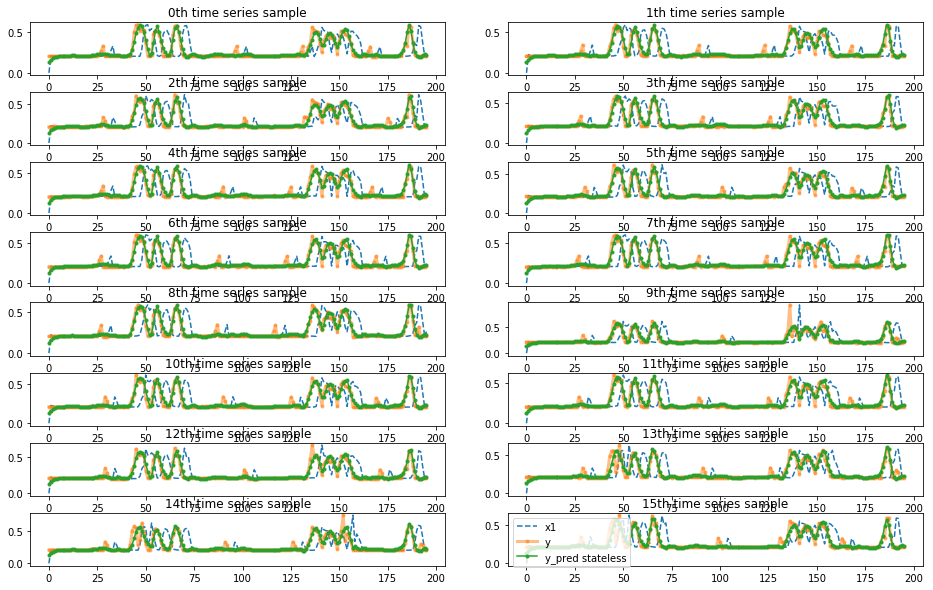

The final validation loss of y_pred stateless is 0.001605


In [58]:
y_pred_stateless = model_stateless.predict(X_train)
plot_examples(X_train,y_train,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

### conclusion

Obviously, the model capture the crashes in 2017 but failed in predicting what happens in 2018.

As crashes are not ''predictable'', we would like to train a model to capture the pitstops rather than the bigger
spikes caused by the ''random'' crashes.

In the next step, let''s try to modify the loss function to suppress the effects of crashes and emphysize on 
pitstops. After all, the ranking are influenced more by pitstops.
